In [46]:
import pandas as pd
from pyspark.sql.functions import desc,udf,col
 

In [3]:
sql = SQLContext(sc)

accidents = (sql.read
         .format("com.databricks.spark.csv")
         .option("header", "true")
         .load("/resources/Airplane_Crashes.csv"))

In [22]:
print(accidents.printSchema())

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Flight #: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Registration: string (nullable = true)
 |-- cn/In: string (nullable = true)
 |-- Aboard: string (nullable = true)
 |-- Fatalities: string (nullable = true)
 |-- Ground: string (nullable = true)
 |-- Summary: string (nullable = true)

None


In [5]:
#converting string column to integer column
accidents = accidents.withColumn("Fatalitiestmp", accidents.Fatalities.cast("Integer")).drop("Fatalities").withColumnRenamed("Fatalitiestmp", "Fatalities")

In [70]:
print(accidents.printSchema())

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Flight #: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Registration: string (nullable = true)
 |-- cn/In: string (nullable = true)
 |-- Aboard: string (nullable = true)
 |-- Ground: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Fatalities: integer (nullable = true)

None


## List of top 10 killer operators

In [12]:
import matplotlib
%matplotlib inline  

                          Operator  sum(Fatalities)
0                         Aeroflot           7156.0
1        Military - U.S. Air Force           3717.0
2                       Air France           1734.0
3                American Airlines           1421.0
4       Pan American World Airways           1302.0
5  Military - U.S. Army Air Forces           1070.0
6                 United Air Lines           1021.0
7                          AVIANCA            941.0
8           Turkish Airlines (THY)            891.0
9                  Indian Airlines            863.0


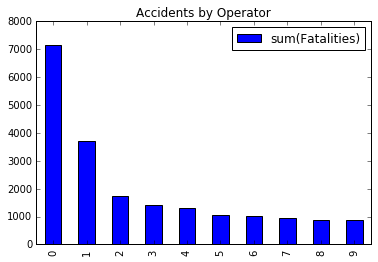

In [23]:

pd_data = accidents.select('Operator','Fatalities').groupby('Operator').sum('Fatalities').sort(desc("sum(Fatalities)")).toPandas().head(10)
print(pd_data)
pd_data.plot(kind='bar',title='Accidents by Operator')


In [25]:
accidents.groupby('Route').count().sort(desc("count")).dropna().toPandas().head(10)

,Route,count
0,,1706
1,Training,81
2,Sightseeing,29
3,Test flight,17
4,Test,6
5,Sao Paulo - Rio de Janeiro,5
6,Saigon - Paris,4
7,Sao Paulo - Porto Alegre,4
8,Bogota - Barranquilla,4
9,Villavicencio - Mitu,4


In [28]:
accidents.groupby('Type').count().sort(desc("count")).toPandas().head(10)

,Type,count
0,Douglas DC-3,334
1,de Havilland Canada DHC-6 Twin Otter 300,81
2,Douglas C-47A,74
3,Douglas C-47,62
4,Douglas DC-4,40
5,Yakovlev YAK-40,37
6,Antonov AN-26,36
7,Junkers JU-52/3m,32
8,Douglas C-47B,29
9,De Havilland DH-4,28


In [29]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer

In [48]:
sentenceDataFrame  = accidents.select('Summary')
regexTokenizer = RegexTokenizer(inputCol="Summary", outputCol="words", pattern="\\W")

In [49]:
from pyspark.sql.types import IntegerType
countTokens = udf(lambda words: len(words), IntegerType())

In [63]:
regexTokenized = regexTokenizer.transform(sentenceDataFrame)
regexTokenized.select("words") \
        .withColumn("tokens", countTokens(col("words"))).show()
words_df = regexTokenized.select("words")

+--------------------+------+
|               words|tokens|
+--------------------+------+
|[during, a, demon...|    86|
|[first, u, s, dir...|    19|
|[the, first, fata...|    18|
|[the, airship, fl...|    35|
|[hydrogen, gas, w...|    25|
|[crashed, into, t...|    16|
|[exploded, and, b...|    15|
|[crashed, near, t...|     7|
|[shot, down, by, ...|     8|
|[shot, down, in, ...|    11|
|[crashed, in, a, ...|     4|
|[shot, down, by, ...|    15|
|[caught, fire, an...|     4|
|[struck, by, ligh...|     8|
|[crashed, into, t...|    18|
|[shot, down, by, ...|     5|
|[shot, down, by, ...|     5|
|[shot, down, by, ...|     7|
|[exploded, and, c...|    12|
|[shot, down, by, ...|    13|
+--------------------+------+
only showing top 20 rows



In [141]:
from pyspark.ml.feature import Word2Vec,NGram
from collections import Counter
from pyspark.ml.feature import StopWordsRemover

In [68]:
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="words", outputCol="result")
model = word2Vec.fit(words_df.select("words"))
result = model.transform(words_df.select("words"))


In [158]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
data_df = remover.transform(words_df.select("words")).select('filtered_words')


In [159]:
data_df.head()

Row(filtered_words=['demonstration', 'flight', 'u', 's', 'army', 'flyer', 'flown', 'orville', 'wright', 'nose', 'dived', 'ground', 'height', 'approximately', '75', 'feet', 'killing', 'lt', 'thomas', 'e', 'selfridge', 'passenger', 'recorded', 'airplane', 'fatality', 'history', 'propellers', 'separated', 'flight', 'tearing', 'loose', 'wires', 'bracing', 'rudder', 'causing', 'loss', 'control', 'aircraft', 'orville', 'wright', 'suffered', 'broken', 'ribs', 'pelvis', 'leg', 'selfridge', 'suffered', 'crushed', 'skull', 'died', 'short', 'time', 'later'])

In [160]:
ngram = NGram(inputCol="filtered_words", outputCol="ngrams")
ngramDataFrame = ngram.transform(data_df)
print(ngramDataFrame.printSchema())


root
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ngrams: array (nullable = true)
 |    |-- element: string (containsNull = false)

None


In [161]:
def line_to_ngrams(line):
    print("val" +str(line))
    return line[0]
    

In [171]:
from operator import add
ng=ngramDataFrame.select("ngrams")
result = ng.flatMap(line_to_ngrams).map(lambda x: (x, 1)) \
                  .reduceByKey(add).sortBy(lambda x: x[1], ascending=False).collect()
    


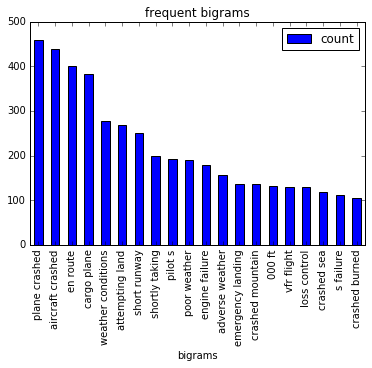

In [178]:
result_df = pd.DataFrame.from_records(result[:20], columns=['bigrams','count'])
result_df.plot(kind='bar',title='frequent bigrams', x = result_df.bigrams )